# A Full End-to-End Deployment of a Machine Learning Algorithm into a Live Production Environment

## How to use scikit-learn, pickle, Flask, Microsoft Azure and ipywidgets to fully deploy a Python machine learning algorithm into a live, production environment

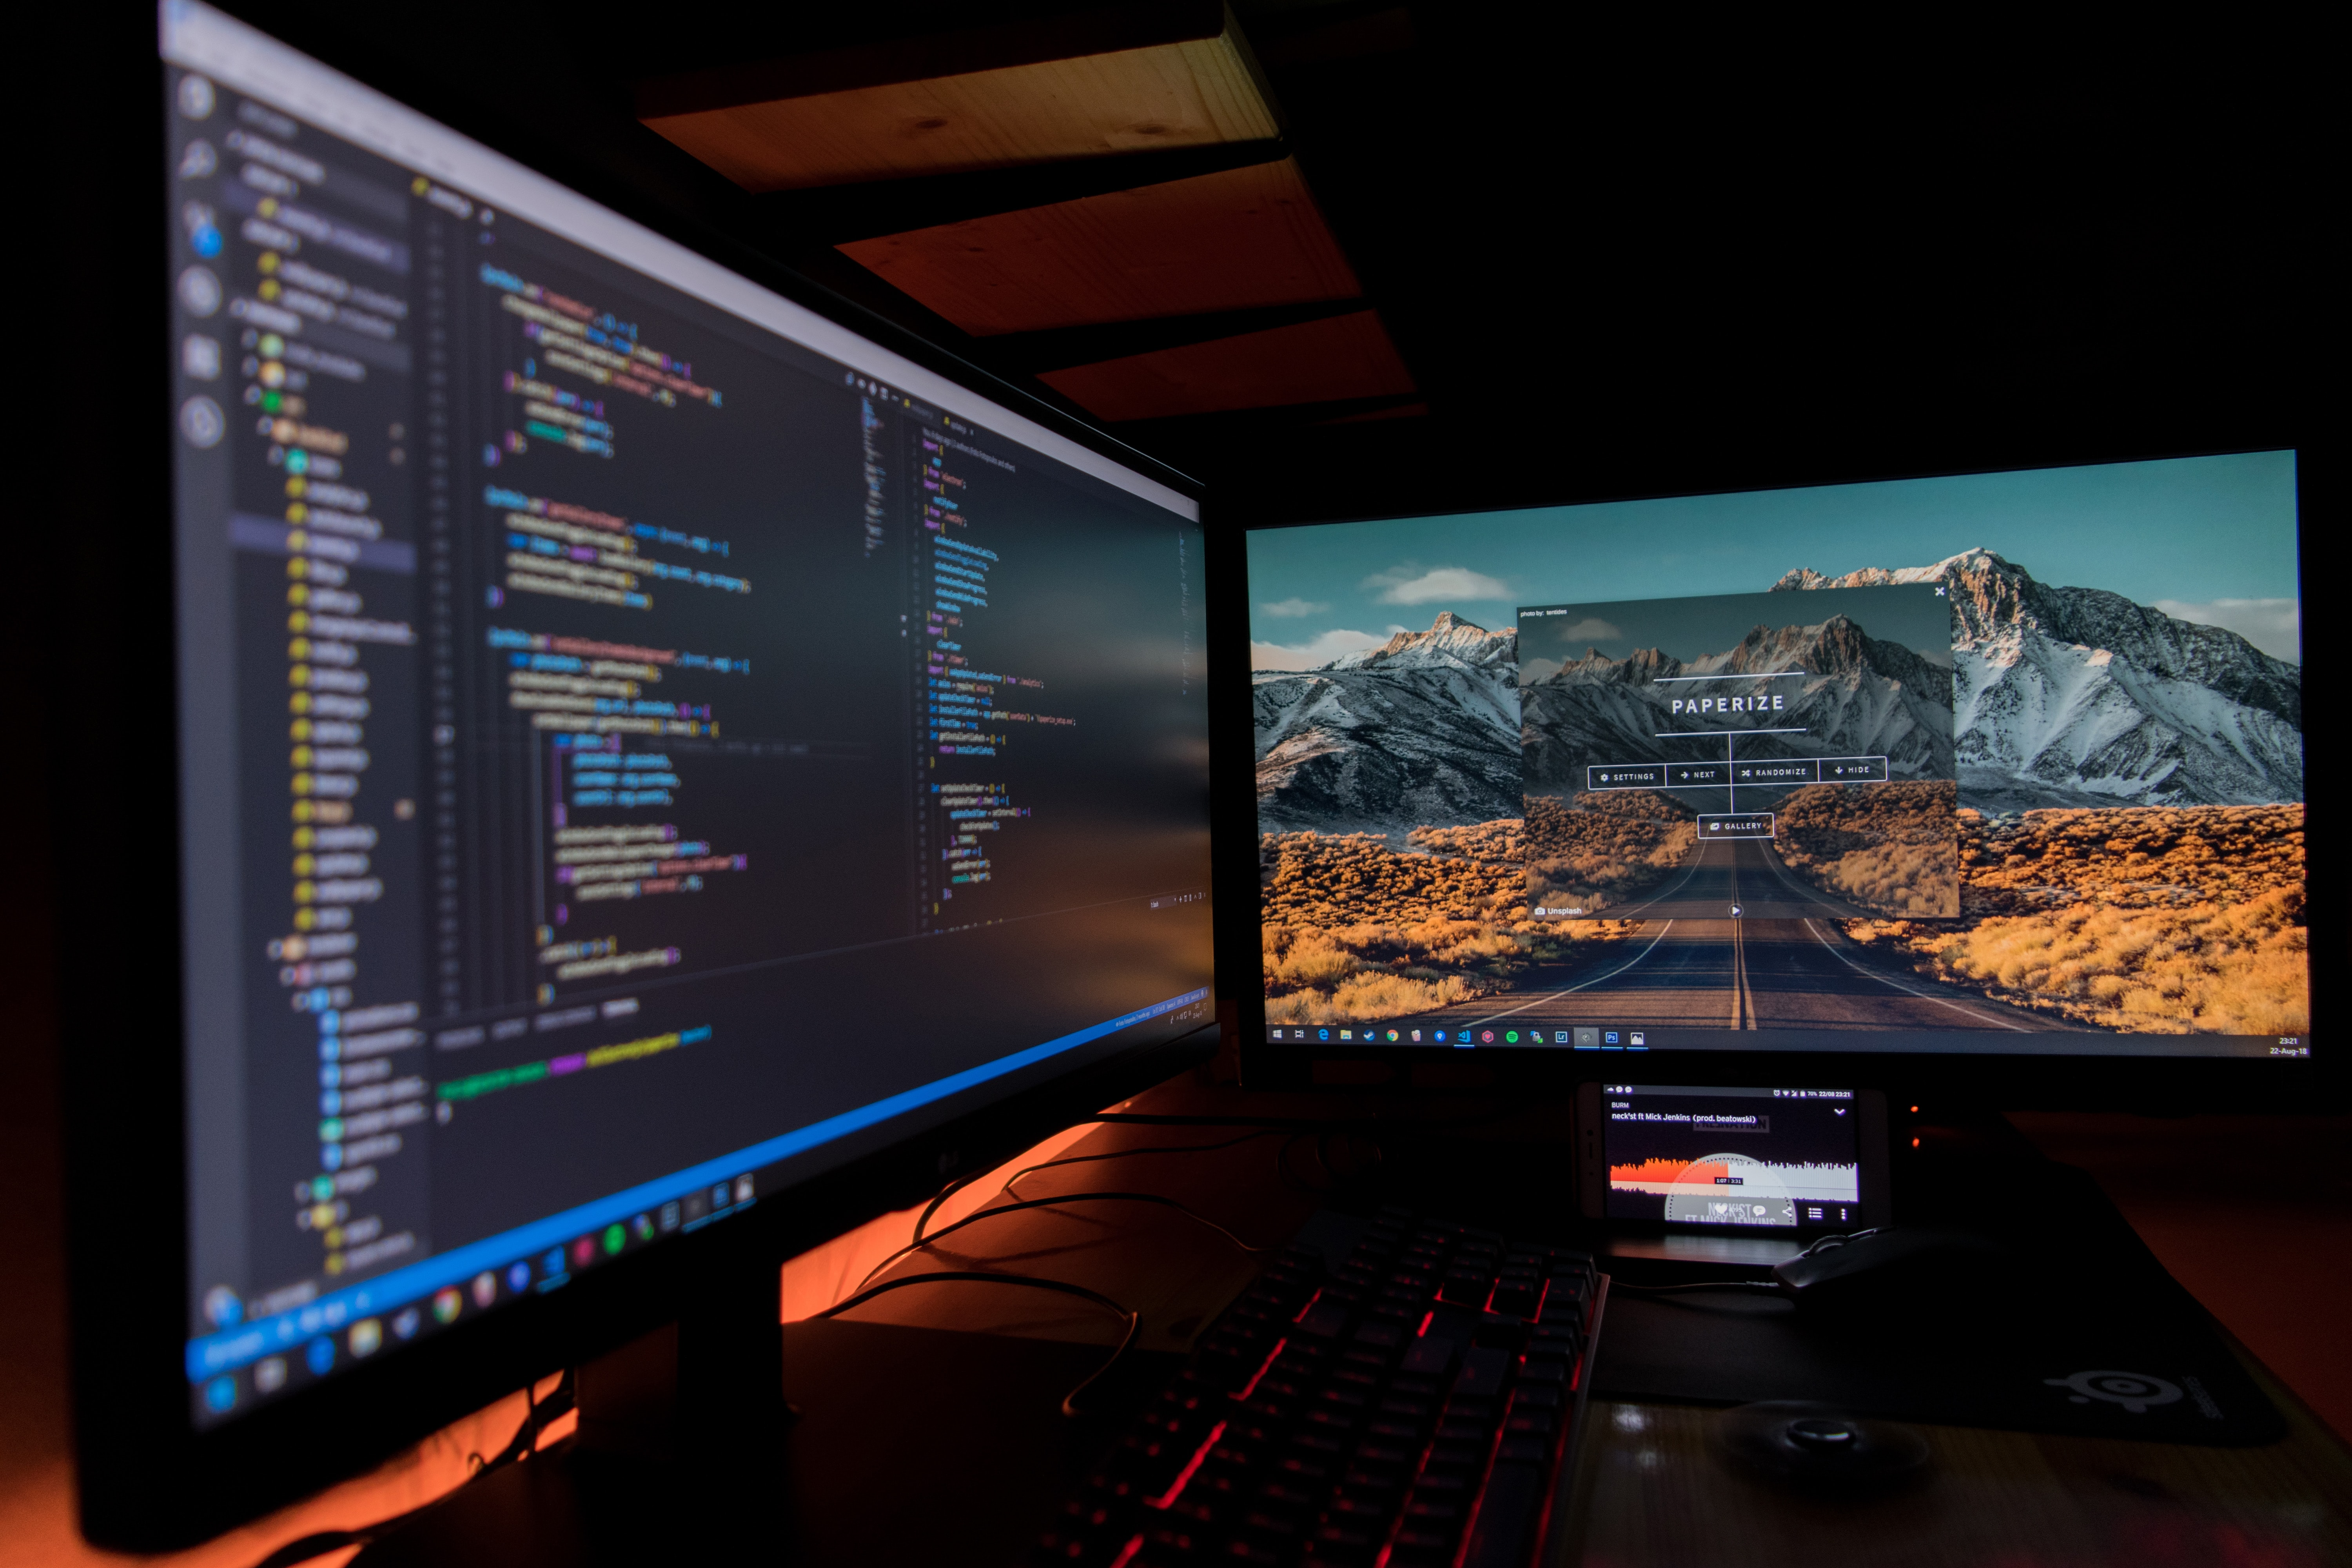
Photo by <a href="https://unsplash.com/@ffstop?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Fotis Fotopoulos</a> on <a href="https://unsplash.com/s/photos/python?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Introduction

In October 2021 I authored an article on "Deploying Machine Learning and Data Science Projects as Public Web Applications" (see https://towardsdatascience.com/deploying-machine-learning-and-data-science-projects-as-public-web-applications-3abc91088c11).

In this article I explored how to deploy Jupyter Notebooks as publicly available web apps using Voila, GitHub and mybinder.

After the article was published I received feedback from readers who were interested in how to push production deployment further to explore how a  machine learning algorithm could be fully deployed into a live production environment so that it could be "consumed" in a platform-agnostic way and that led to the idea for this article ...

### Step 1: Develop a Machine Learning Algorithm

The first step is to develop the machine learning algorithm that we want to deploy. In the real world this could involve many weeks or months of development time and lots of iteration across the steps of the data science pipeline but for this example I will develop a basic ML algorithm as the main purpose of this article is to find a way to deploy an algorithm for use by "consumers".

I selected a dataset from kaggle (https://www.kaggle.com/prathamtripathi/drug-classification) that has been created by the author with a "CC0: Public Domain" license which means that it has no copyright and that it may be used in other work with no restrictions (see https://creativecommons.org/publicdomain/zero/1.0/ for details).

The Python code to develop a predictive machine learning algorithm to classify drug prescriptions given a range of patient criteria is as follows -

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score

df_drug = pd.read_csv("drug200.csv")

label_encoder = LabelEncoder()

categorical_features = [feature for feature in df_drug.columns if df_drug[feature].dtypes == 'O']
for feature in categorical_features:
    df_drug[feature]=label_encoder.fit_transform(df_drug[feature])
    
X = df_drug.drop("Drug", axis=1)
y = df_drug["Drug"]

model = DecisionTreeClassifier(criterion="entropy")
model.fit(X, y)

kfold = KFold(random_state=42, shuffle=True)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
print(cv_results.mean(), cv_results.std())

0.99 0.012247448713915901


At this point we can see that we have a machine learning algorithm trained to predict drug presriptions and that cross validation (i.e. folding the data) has been used to evaluate the model accuracy at 99%.

So far, so good ...

We are going to deploy this model into a production environment and although it is a simple example we would not want to have to retrain our model in the live environment every time a user wanted to predict a drug presription, hence our next step is to preserve the state of our trained model using ``pickle`` ...

In [3]:
import pickle

pickle_file = open('model.pkl', 'ab')
pickle.dump(model, pickle_file)                     
pickle_file.close()

Now whenever we want to use the trained model, we simply need to reload its state from the ``model.pkl`` file rather than re-executing the training step.

### Step 2: Make an Individual Prediction from the Trained Model

I am going to make a couple of assumptions in step 2 -

1. Consumers of the machine learning algorithm have a requirements to make predictions for individual patients rather than a batch of patients.
2. Those consumers wish to communicate with the algorithm using text-like values for the parameters (for example blood pressure = "NORMAL" or "HIGH" rather than their label encoded equivalents like 0 and 1.

Therefore, we will start by reviewing what the values are for all of the label encoded categorical features used as an input to the algorithm ...

In [13]:
df_drug = pd.read_csv("drug200.csv")

label_encoder = LabelEncoder()

categorical_features = [feature for feature in df_drug.columns if df_drug[feature].dtypes == 'O']
for feature in categorical_features:
    print(feature, list(df_drug[feature].unique()), list(label_encoder.fit_transform(df_drug[feature].unique())), "\n")

Sex ['F', 'M'] [0, 1] 

BP ['HIGH', 'LOW', 'NORMAL'] [0, 1, 2] 

Cholesterol ['HIGH', 'NORMAL'] [0, 1] 

Drug ['DrugY', 'drugC', 'drugX', 'drugA', 'drugB'] [0, 3, 4, 1, 2] 



And there we have it, a list of each categorical feature with the unique values that appear in the data and the corresponding numerical values as transformed by the ``LabelEncoder()``.

Armed with this knowledge we can provide a set of dictionaries that map the text-like values (e.g. "HIGH", "LOW" etc.) into their encoded equivalents and then develop a simple function to make an individual predictions as follows ...

In [14]:
gender_map = {"F": 0, "M": 1}
bp_map = {"HIGH": 0, "LOW": 1, "NORMAL": 2}
cholestol_map = {"HIGH": 0, "NORMAL": 1}
drug_map = {0: "DrugY", 3: "drugC", 4: "drugX", 1: "drugA", 2: "drugB"}

def predict_drug(Age, 
                 Sex, 
                 BP, 
                 Cholesterol, 
                 Na_to_K):

    # 1. Read the machine learning model from its saved state ...
    pickle_file = open('model.pkl', 'rb')     
    model = pickle.load(pickle_file)
    
    # 2. Transform the "raw data" passed into the function to the encoded / numerical values using the maps / dictionaries
    Sex = gender_map[Sex]
    BP = bp_map[BP]
    Cholesterol = cholestol_map[Cholesterol]

    # 3. Make an individual prediction for this set of data
    y_predict = model.predict([[Age, Sex, BP, Cholesterol, Na_to_K]])[0]

    # 4. Return the "raw" version of the prediction i.e. the actual name of the drug rather than the numerical encoded version
    return drug_map[y_predict] 

This implementation can then be verified by invoking the function to make some predictions based on values from the original data so that we know what the outputs should be ...

In [15]:
predict_drug(47, "F", "LOW",  "HIGH", 14)

'drugC'

In [16]:
predict_drug(60, "F", "LOW",  "HIGH", 20)

'DrugY'

Note that our ``predict_drug`` function does not need to train the model, rather it "rehydrates" the model that previously had its state saved by ``pickle`` into the ``model.pkl`` file and we can see from the output that the predictions for drug recommendation are correct.

### Step 3: Develop a Web Service Wrapper

Everything is looking good so far but here is the major problem: clients or consumers of our machine learning algorithm must be written in the Python programming language and not only that, we must have the capability of changing and modifying the application.

What if a 3rd party application wants to use and consume our algorithm and what if this 3rd party application is not written in Python? Perhaps it is written in Java, C#, JavaScript or some other non-Python language.

This is where web services come in. A web service is a "wrapper" that receives requests from clients and consumers using http GET and http PUT commands, invokes the Python code and returns the result as an HTML response.

This means that the clients and callers only need to be able to formulate HTTP requests and nearly all programming languages and environments will have a way of doing this.

In the Python world there are several different approaches available but the one I have selected is to use ``flask`` to construct our web service wrapper.

The code is not very complicated but it can be challenging to get VS Code configured to enable developers to debug a flask application. If you need a tutorial for this step please check out my article titled "How to Debug Flask Applications in VS Code" which can be found here - https://towardsdatascience.com/how-to-debug-flask-applications-in-vs-code-c65c9bdbef21.

Here is the wrapper code for the web service ...

In [17]:
from flask import Flask

import pickle
from flask import request, jsonify

app = Flask(__name__)

gender_map = {"F": 0, "M": 1}
bp_map = {"HIGH": 0, "LOW": 1, "NORMAL": 2}
cholesterol_map = {"HIGH": 0, "NORMAL": 1}
drug_map = {0: "DrugY", 3: "drugC", 4: "drugX", 1: "drugA", 2: "drugB"}

def predict_drug(Age, 
                 Sex, 
                 BP, 
                 Cholesterol, 
                 Na_to_K):

    # 1. Read the machine learning model from its saved state ...
    pickle_file = open('model.pkl', 'rb')     
    model = pickle.load(pickle_file)
    
    # 2. Transform the "raw data" passed into the function to the encoded / numerical values using the maps / dictionaries
    Sex = gender_map[Sex]
    BP = bp_map[BP]
    Cholesterol = cholesterol_map[Cholesterol]

    # 3. Make an individual prediction for this set of data
    y_predict = model.predict([[Age, Sex, BP, Cholesterol, Na_to_K]])[0]

    # 4. Return the "raw" version of the prediction i.e. the actual name of the drug rather than the numerical encoded version
    return drug_map[y_predict]  

@app.route("/")
def hello():
    return "A test web service for accessing a machine learning model to make drug recommendations v2."

@app.route('/drug', methods=['GET'])
def api_all():
#    return jsonify(data_science_books)

    Age = int(request.args['Age'])
    Sex = request.args['Sex']
    BP = request.args['BP']
    Cholesterol = request.args['Cholesterol']
    Na_to_K = float(request.args['Na_to_K'])

    drug = predict_drug(Age, Sex, BP, Cholesterol, Na_to_K)

    #return(jsonify(drug))
    return(jsonify(recommended_drug = drug))

Start the VS Code IDE from the Anaconda Navigator page (or by starting and Anaconda Command Prompt and typing ``code``). This will start VS Code with the conda base environment which is required to run and debug the flask application.

The web service can be started from inside VS Code by clicking on "Run and Debug" and then selecting "Flask Launch and debug a Flask web application" -

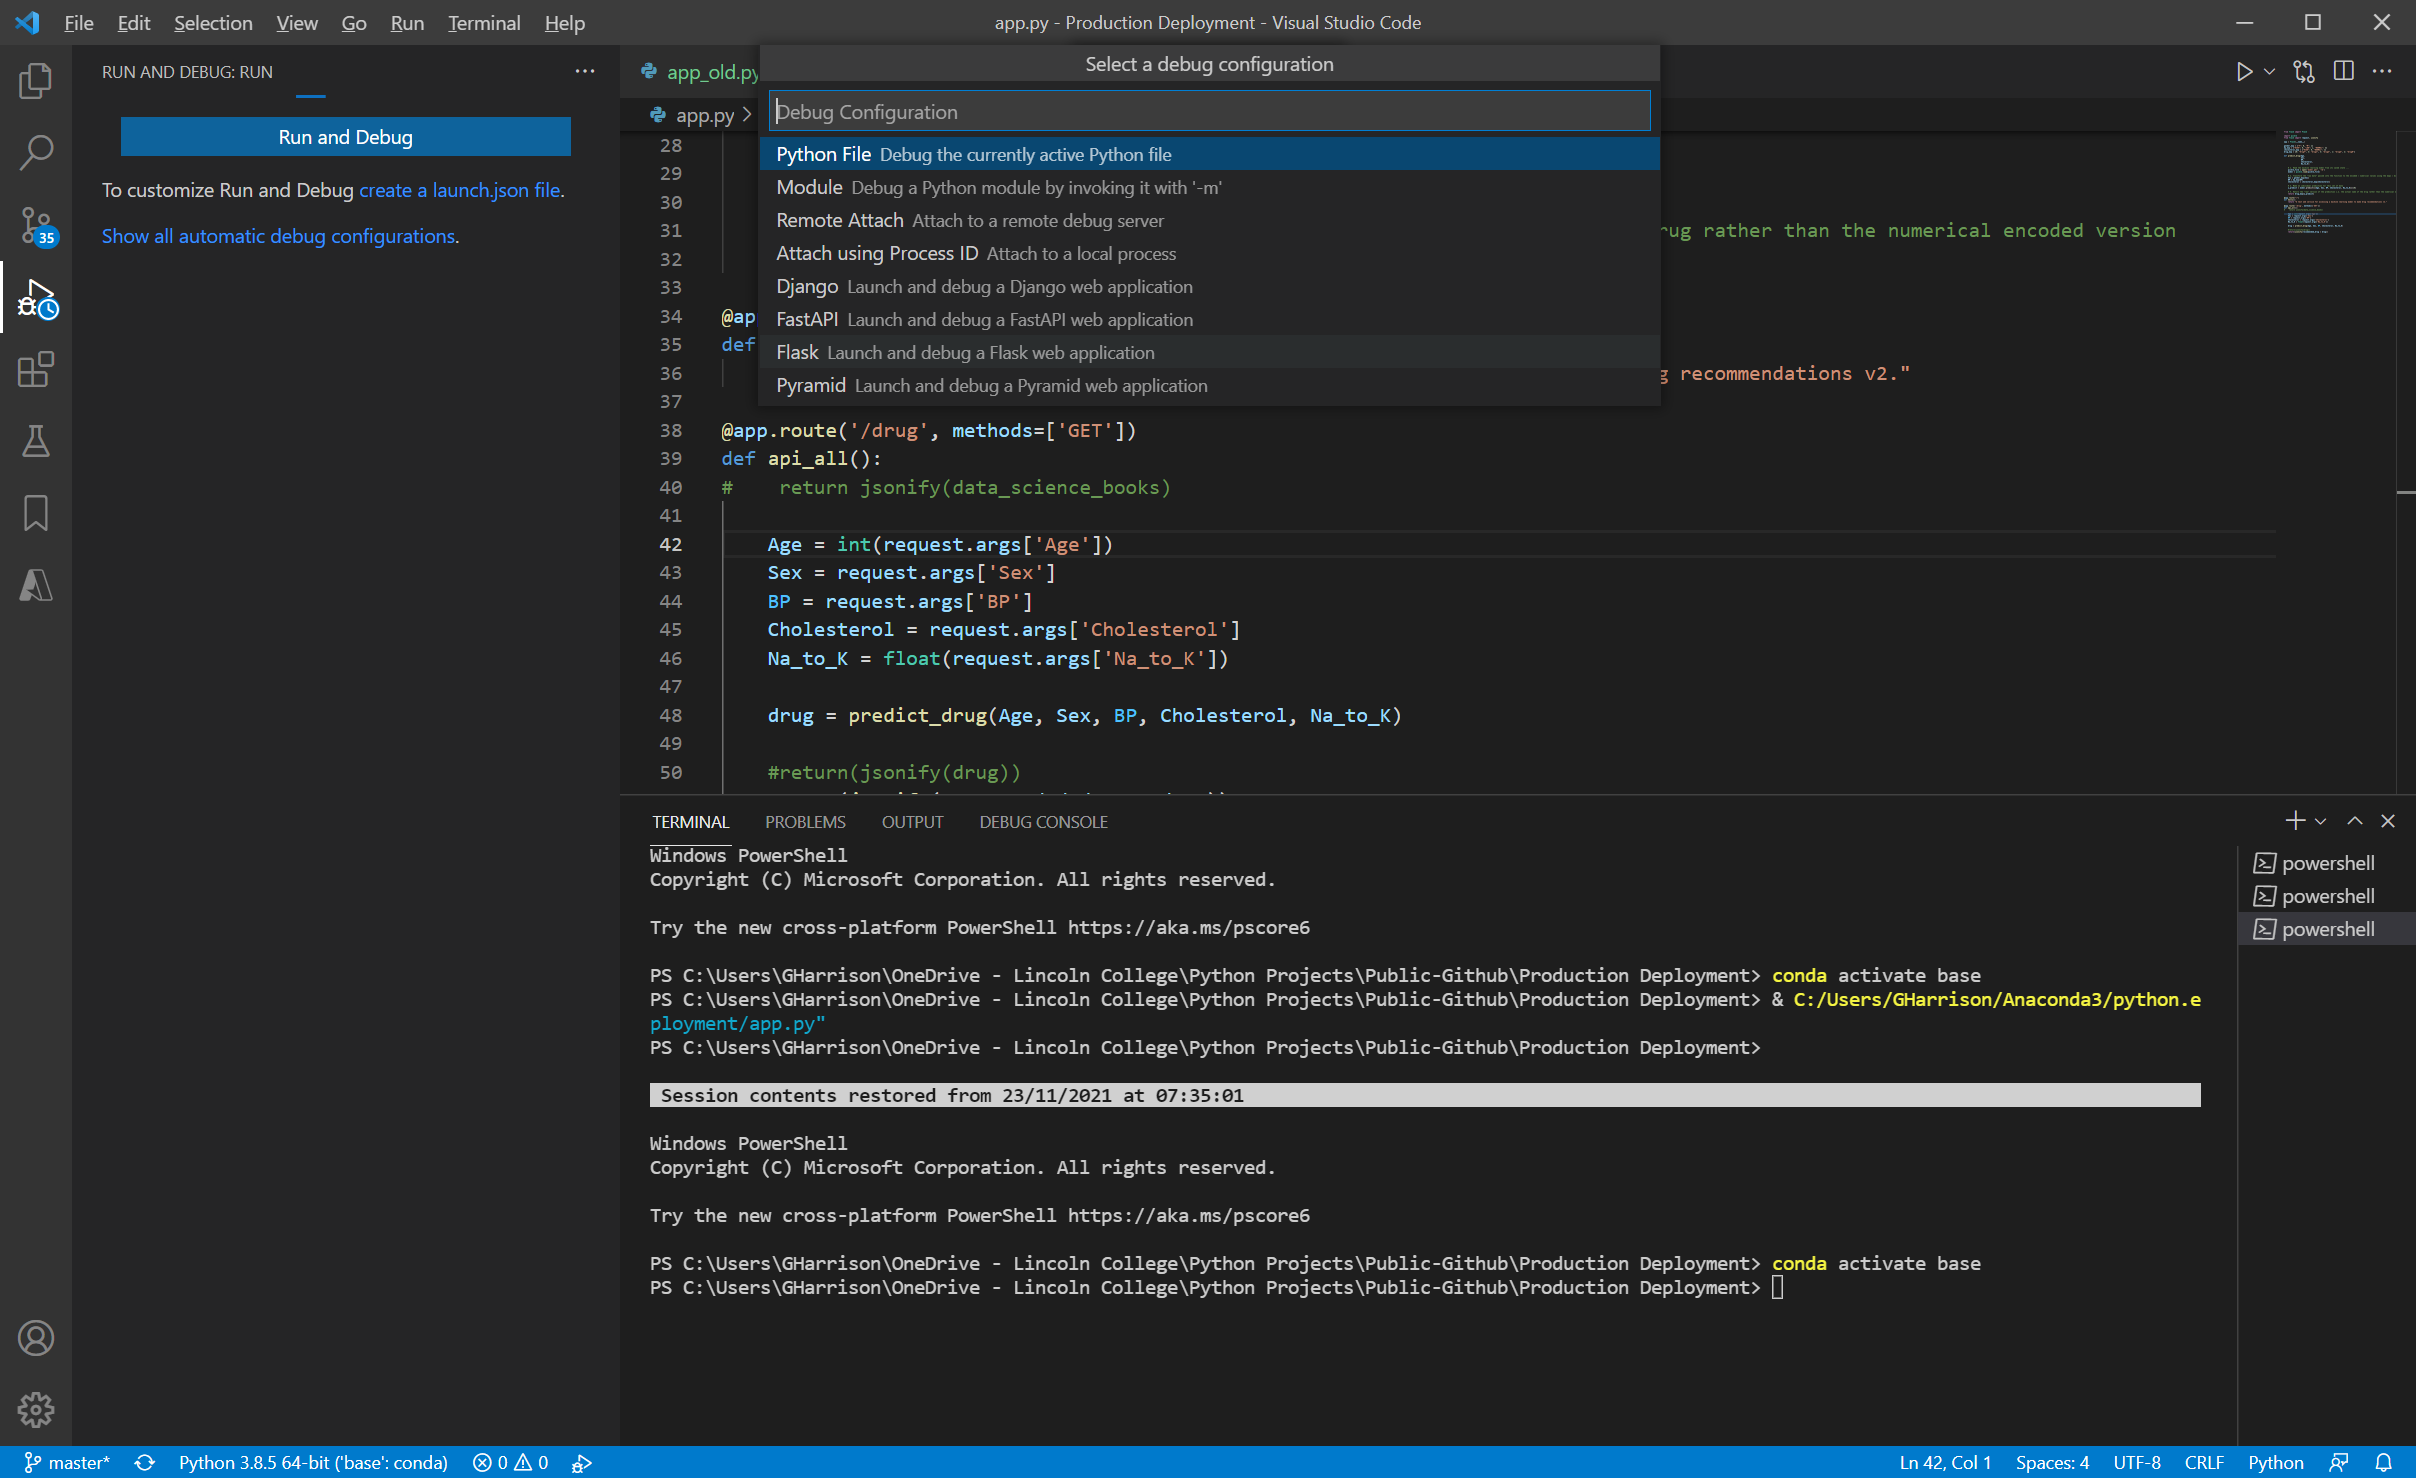

If everything has gone to plan the last message in the TERMINAL window should be ``Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)`` which indicates that your flask web application is up and running.

You should now test you web service using one of these methods -

1. Open a web browser and enter: http://127.0.0.1:5000/drug?Age=60&Sex=F&BP=LOW&Cholesterol=HIGH&Na_to_K=20
2. Open an anaconda command prompt and enter: ``curl -X GET "http://127.0.0.1:5000/drug?Age=60&Sex=F&BP=LOW&Cholesterol=HIGH&Na_to_K=20"``

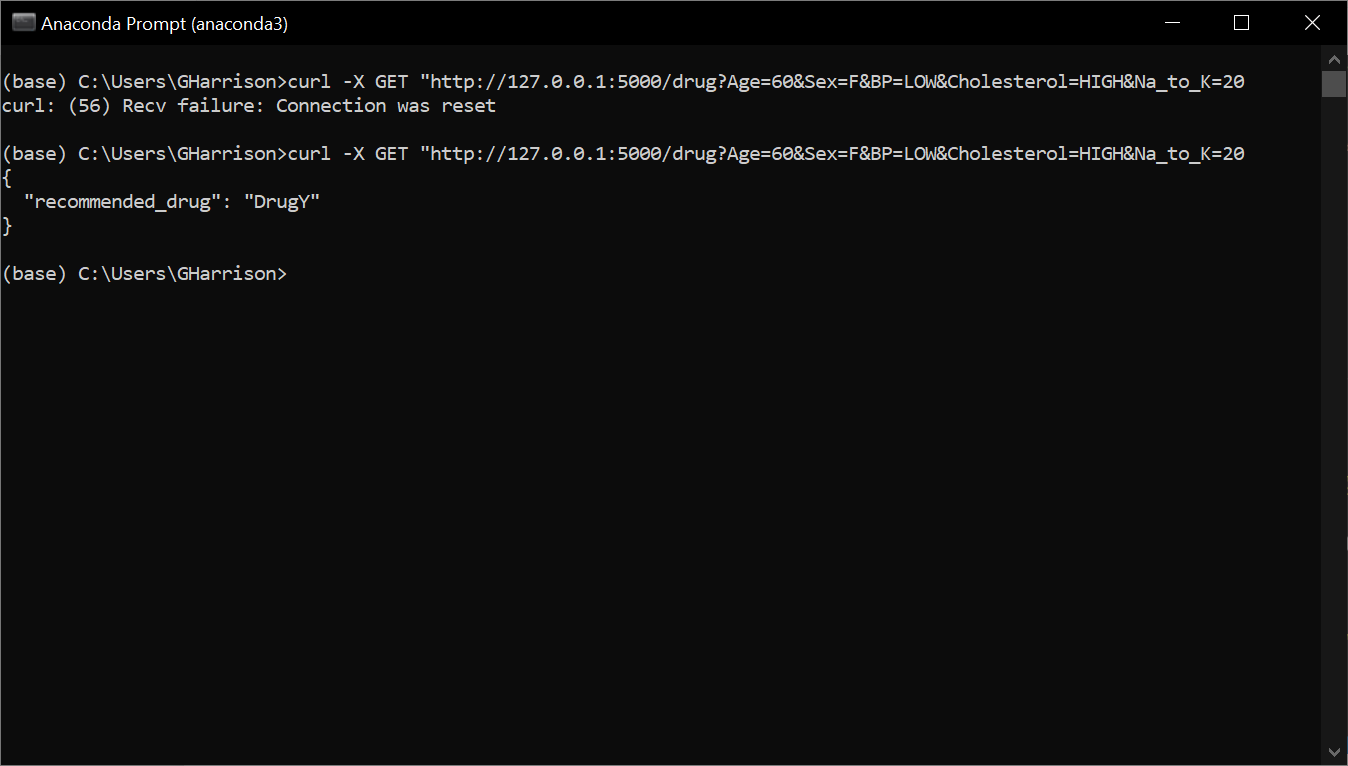

If you want to find out more about developing ``flask`` applications and web services, these articles are a great place to start -

- https://programminghistorian.org/en/lessons/creating-apis-with-python-and-flask
- https://code.visualstudio.com/docs/python/tutorial-flask

### Step 4: Deploy the Web Service to Microsoft Azure

We now have a predictive machine learning algorithm that can predict drug prescriptions with 99% accuracy, we have a helper function that can make individual predictions and we have a web service wrapper that enables these components to be called from a browser or command line.

However all of this is still only callable from the development environment. The next stage is to deploy everything into the cloud so that clients can "consume" the web service over the public Internet.

There are many different public services available for web app deployment including -

- Google - https://cloud.google.com/appengine/docs/standard/python3/building-app/writing-web-service
- Amazon Web Services - https://medium.com/@rodkey/deploying-a-flask-application-on-aws-a72daba6bb80
- Microsoft Azure - https://medium.com/@nikovrdoljak/deploy-your-flask-app-on-azure-in-3-easy-steps-b2fe388a589e

I have chosen Azure because it is free (for an entry level account), easy-to-use, quick and fully integrated with VS Code which is my favourite development environment.

#### Step 4.1: Add the Azure App Service Extension to VS Code

Switch tasks into VS Code, go to "Extensions" (Ctrl+Shft_X) and add in the "Azure App Service" extension. Once the extension is added you will see a new Azure icon in the Activity Bar -

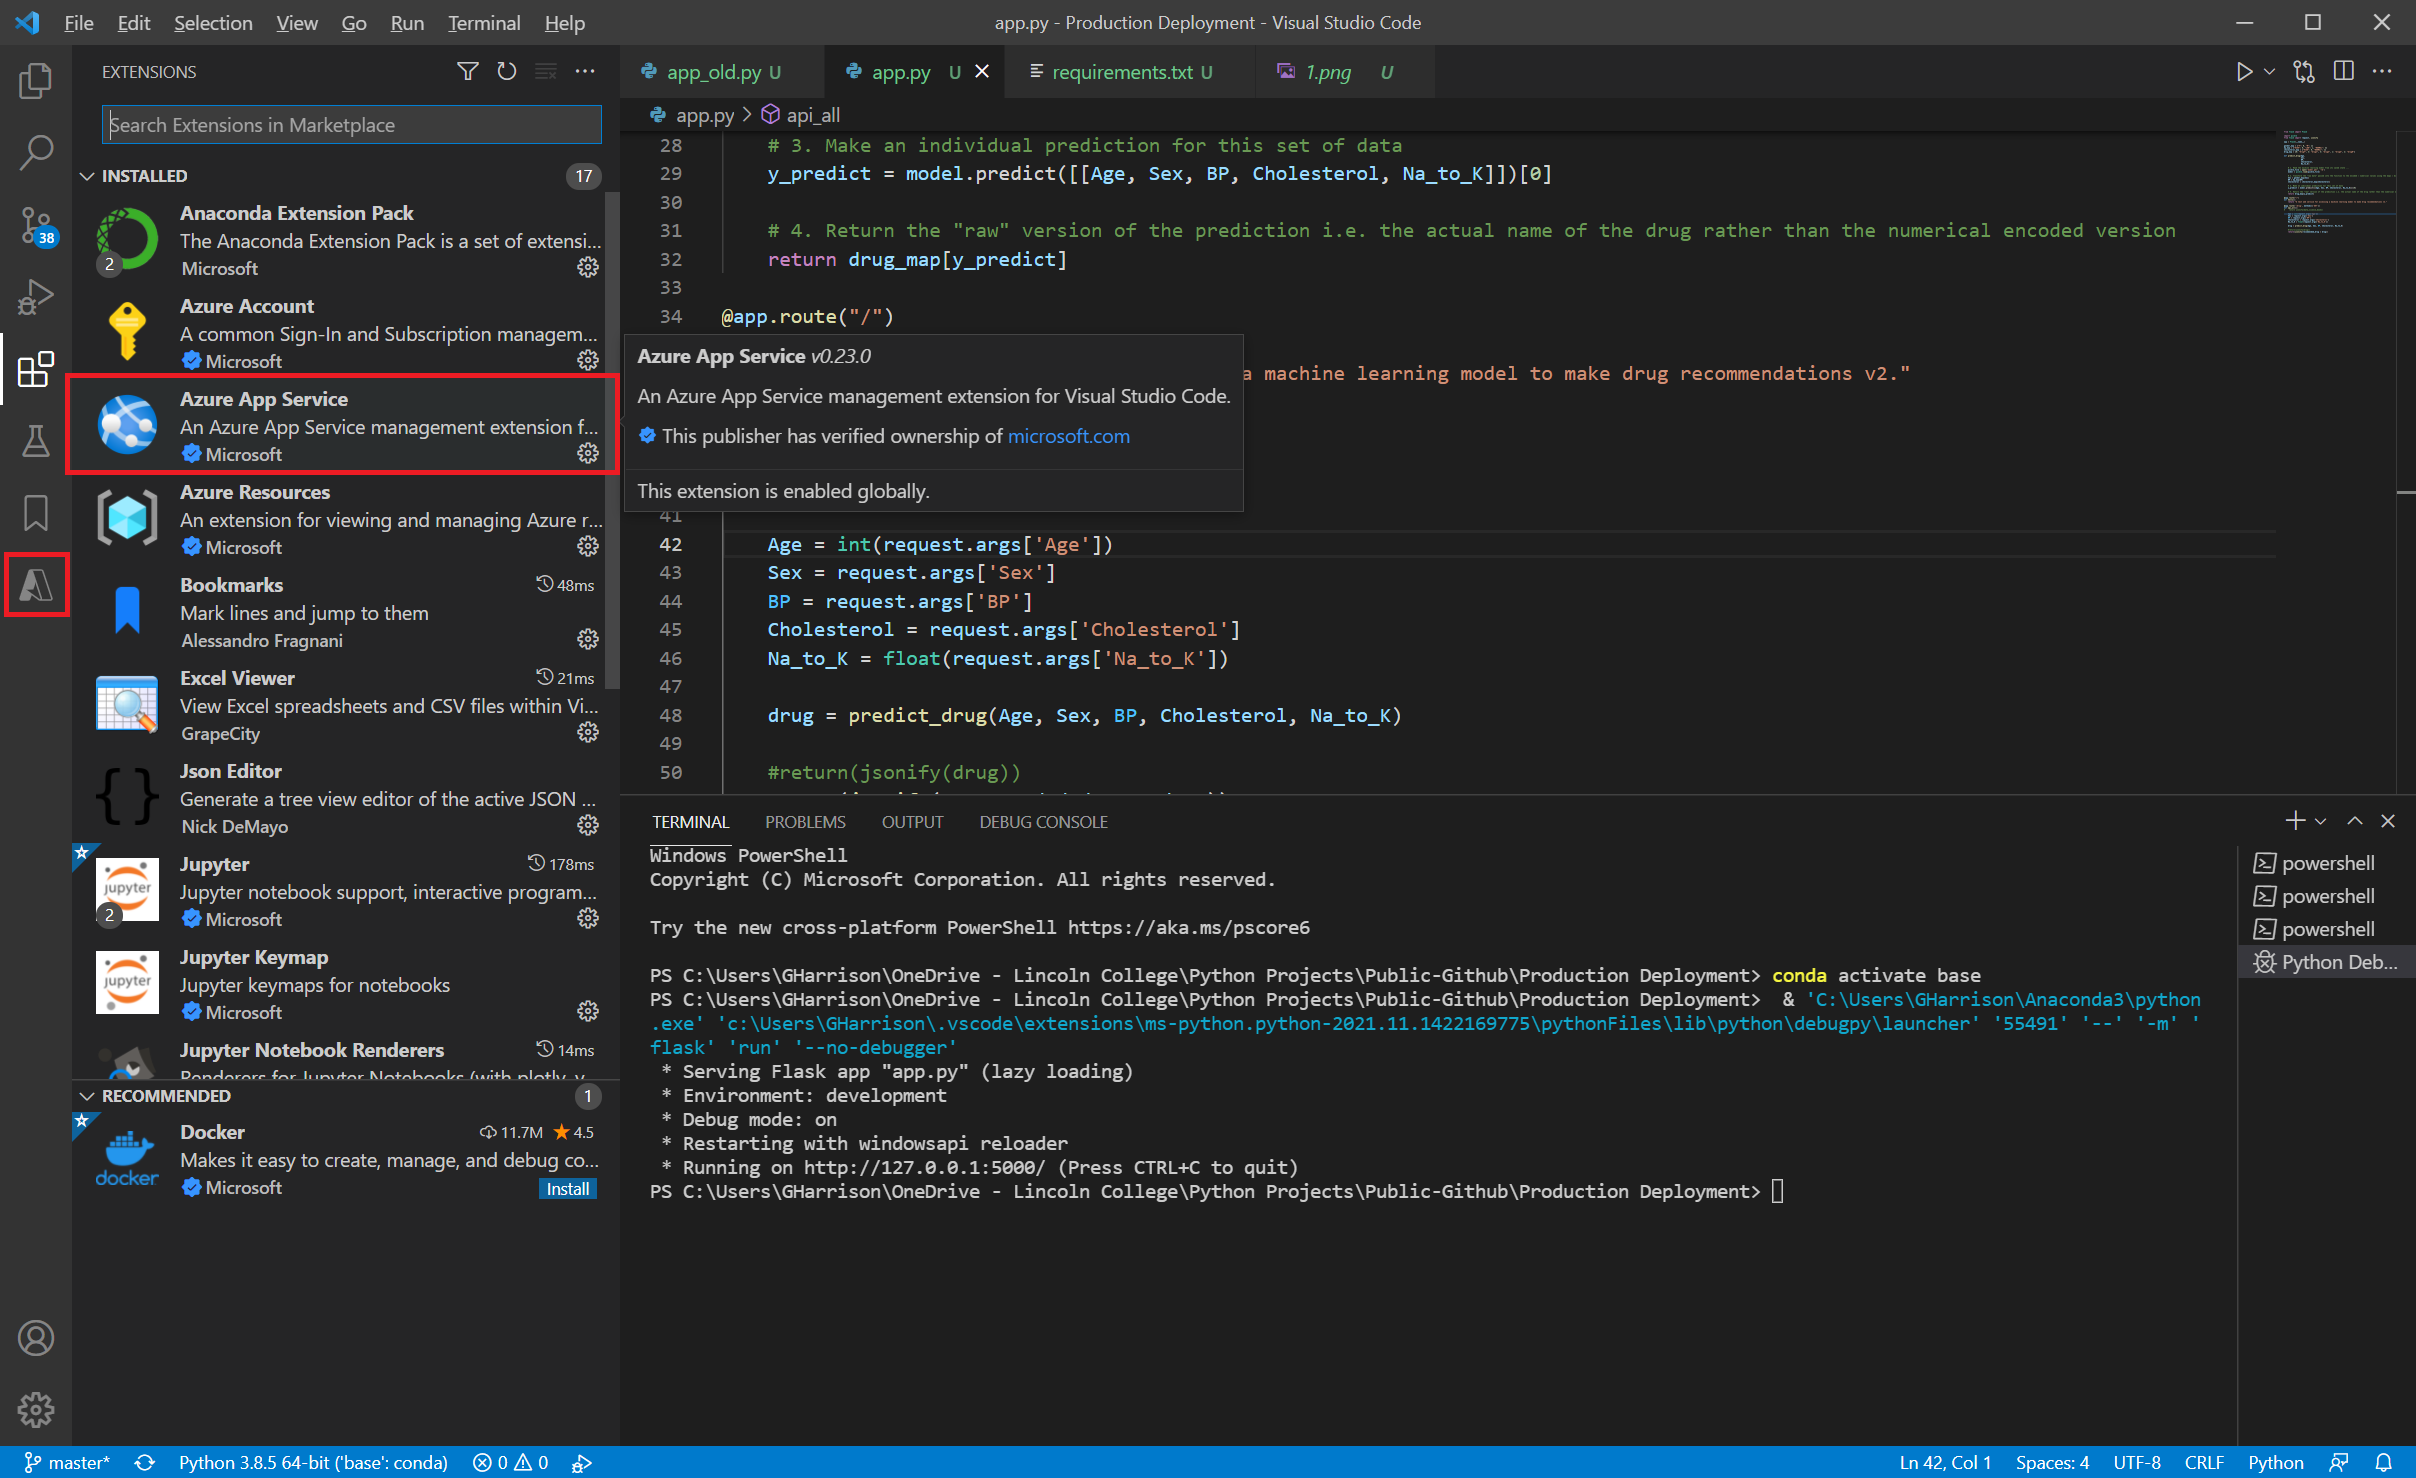

#### Step 4.1: Create an Azure Account

You must have an account to begin deployments into the Azure cloud and you must provide credit card details during the registration process. However you will not be charged unless you specifically opt to move away from the free license.

You can follow the instructions on this page - https://azure.microsoft.com/en-gb/free/ to create your free Azure account via a browser, but the easiest way is to click on the new Azure icon in the Activity Bar and choose "Create a Free Azure Account" (or "Sign in to Azure" if you already have one) -

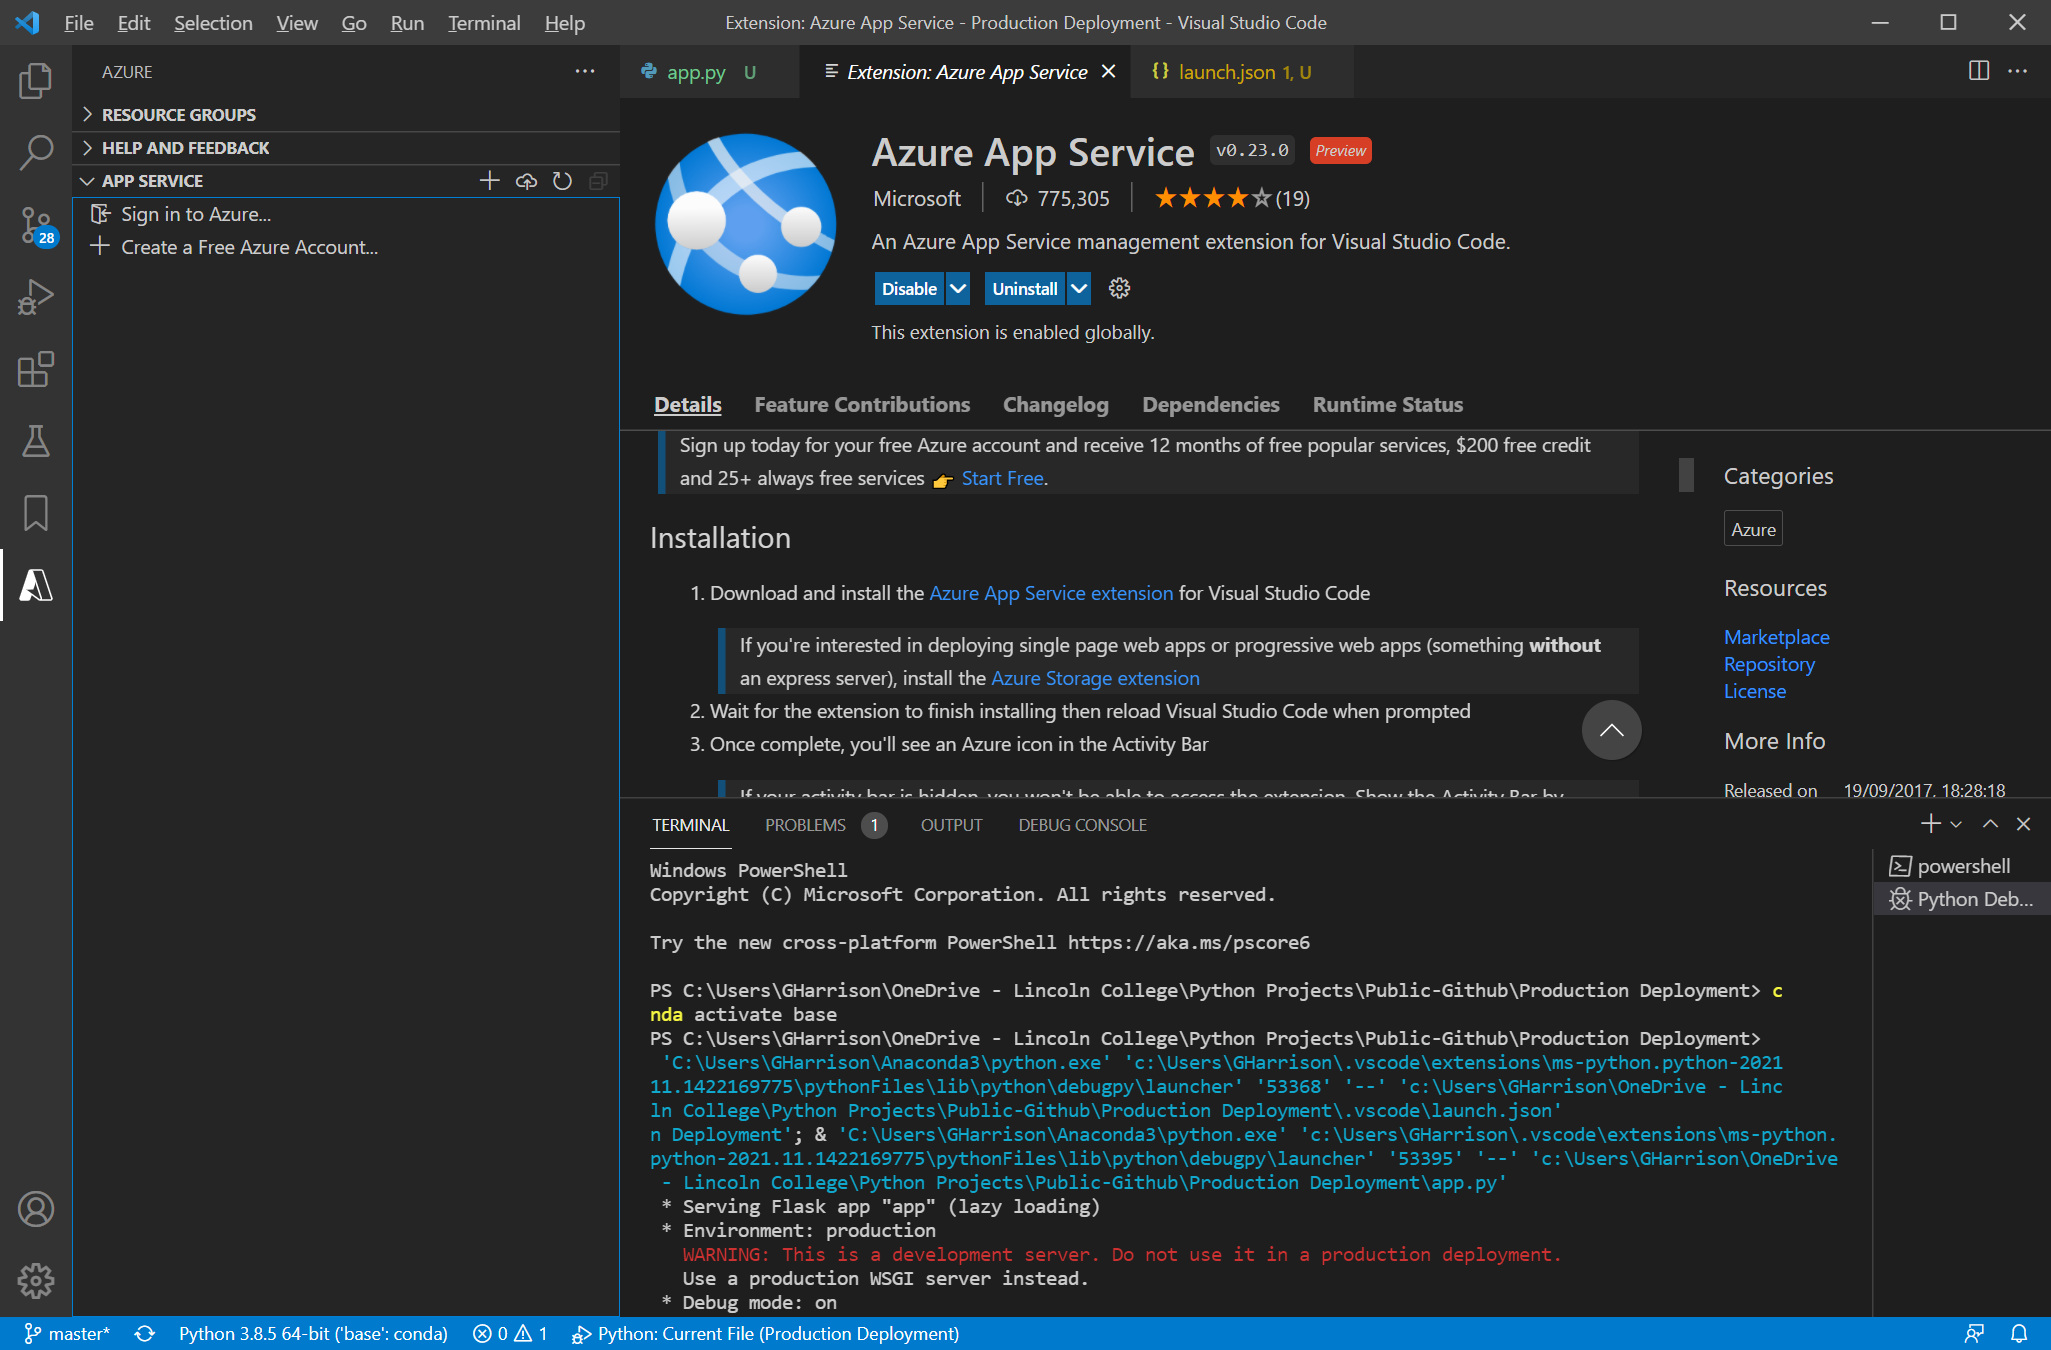

#### Step 4.3: Create an Azure Web App

The next step is to create an Azure web app to host your application by clicking on the "+" sign in the "APP SERVICE" window. You will be prompted for a name for the app. The name will be used in the final URL and it must be unique but other than that the name is not particularly important.

When prompted for a license type choose "Free Trial" - your web app will now be created and you are ready to deploy.

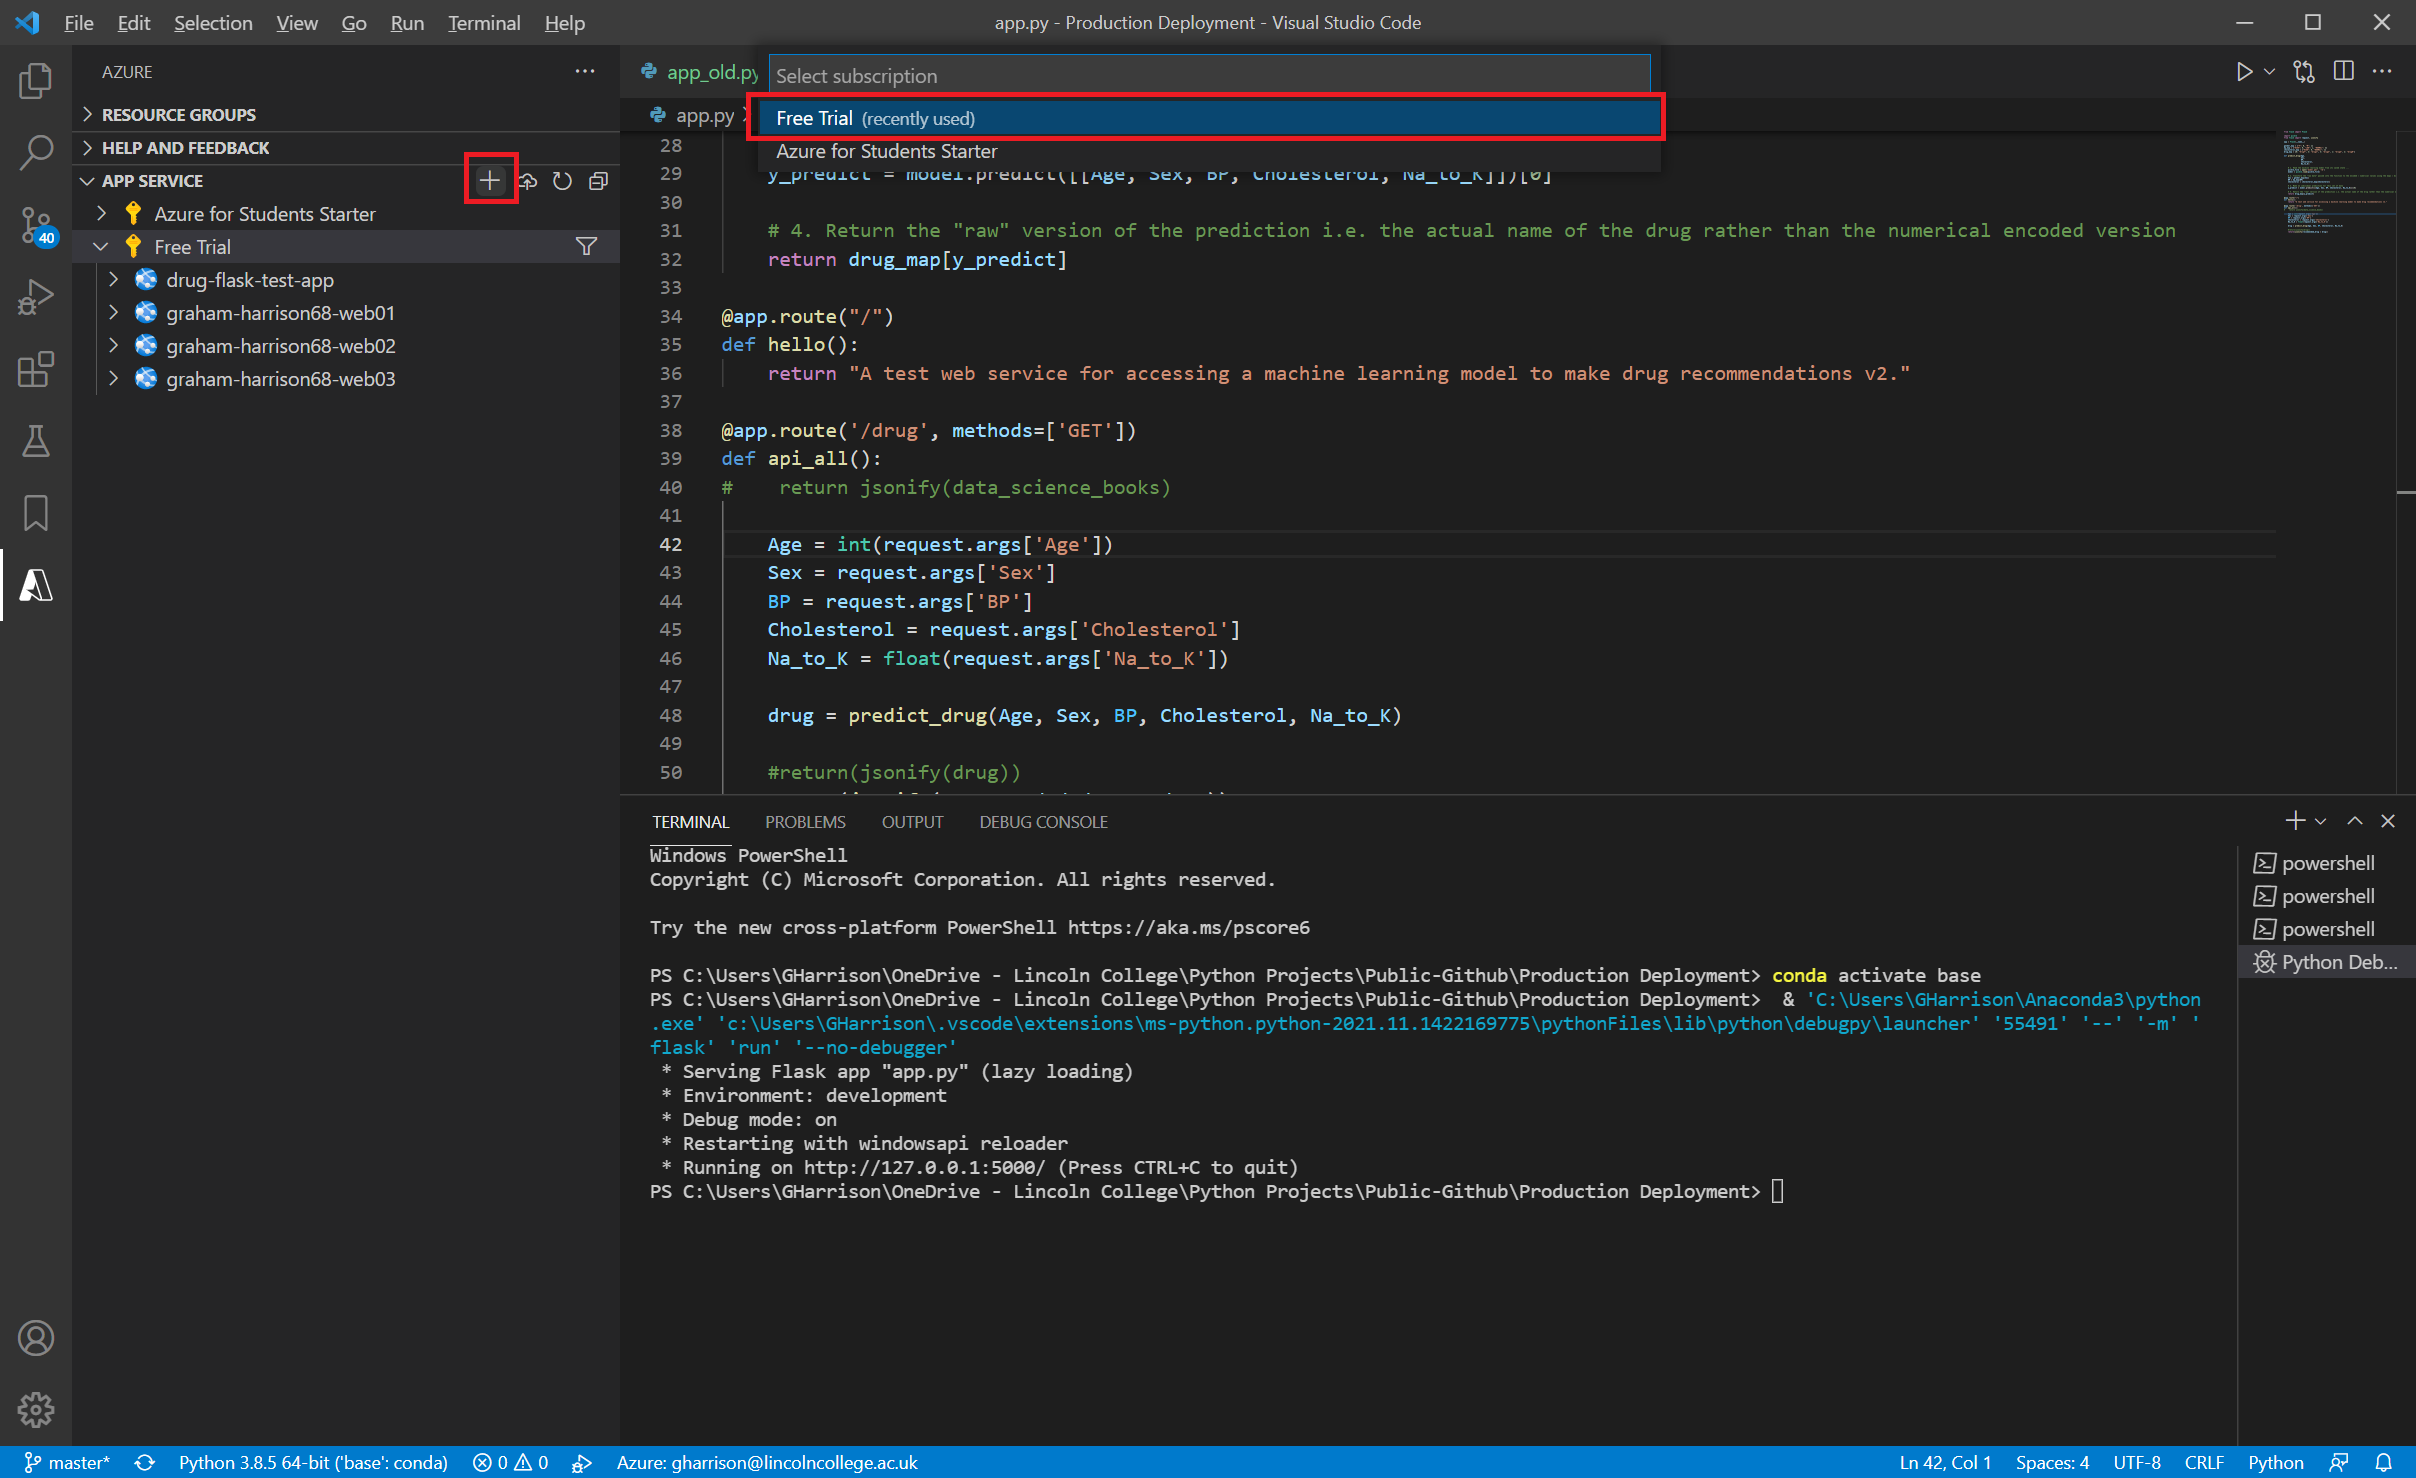

#### Step 4.4 Create a "requirements.txt" deployment file

Before you can deploy the app to Azure you must create a "requirements.txt" file in the same folder as your Flask web app that contains a list of all of the dependencies and libraries that Azure must install in order to run your application. This step is vital as if the libraries are not in the deployed environment the app will crash.

The contents of ``requirements.txt`` for our app are as follows -

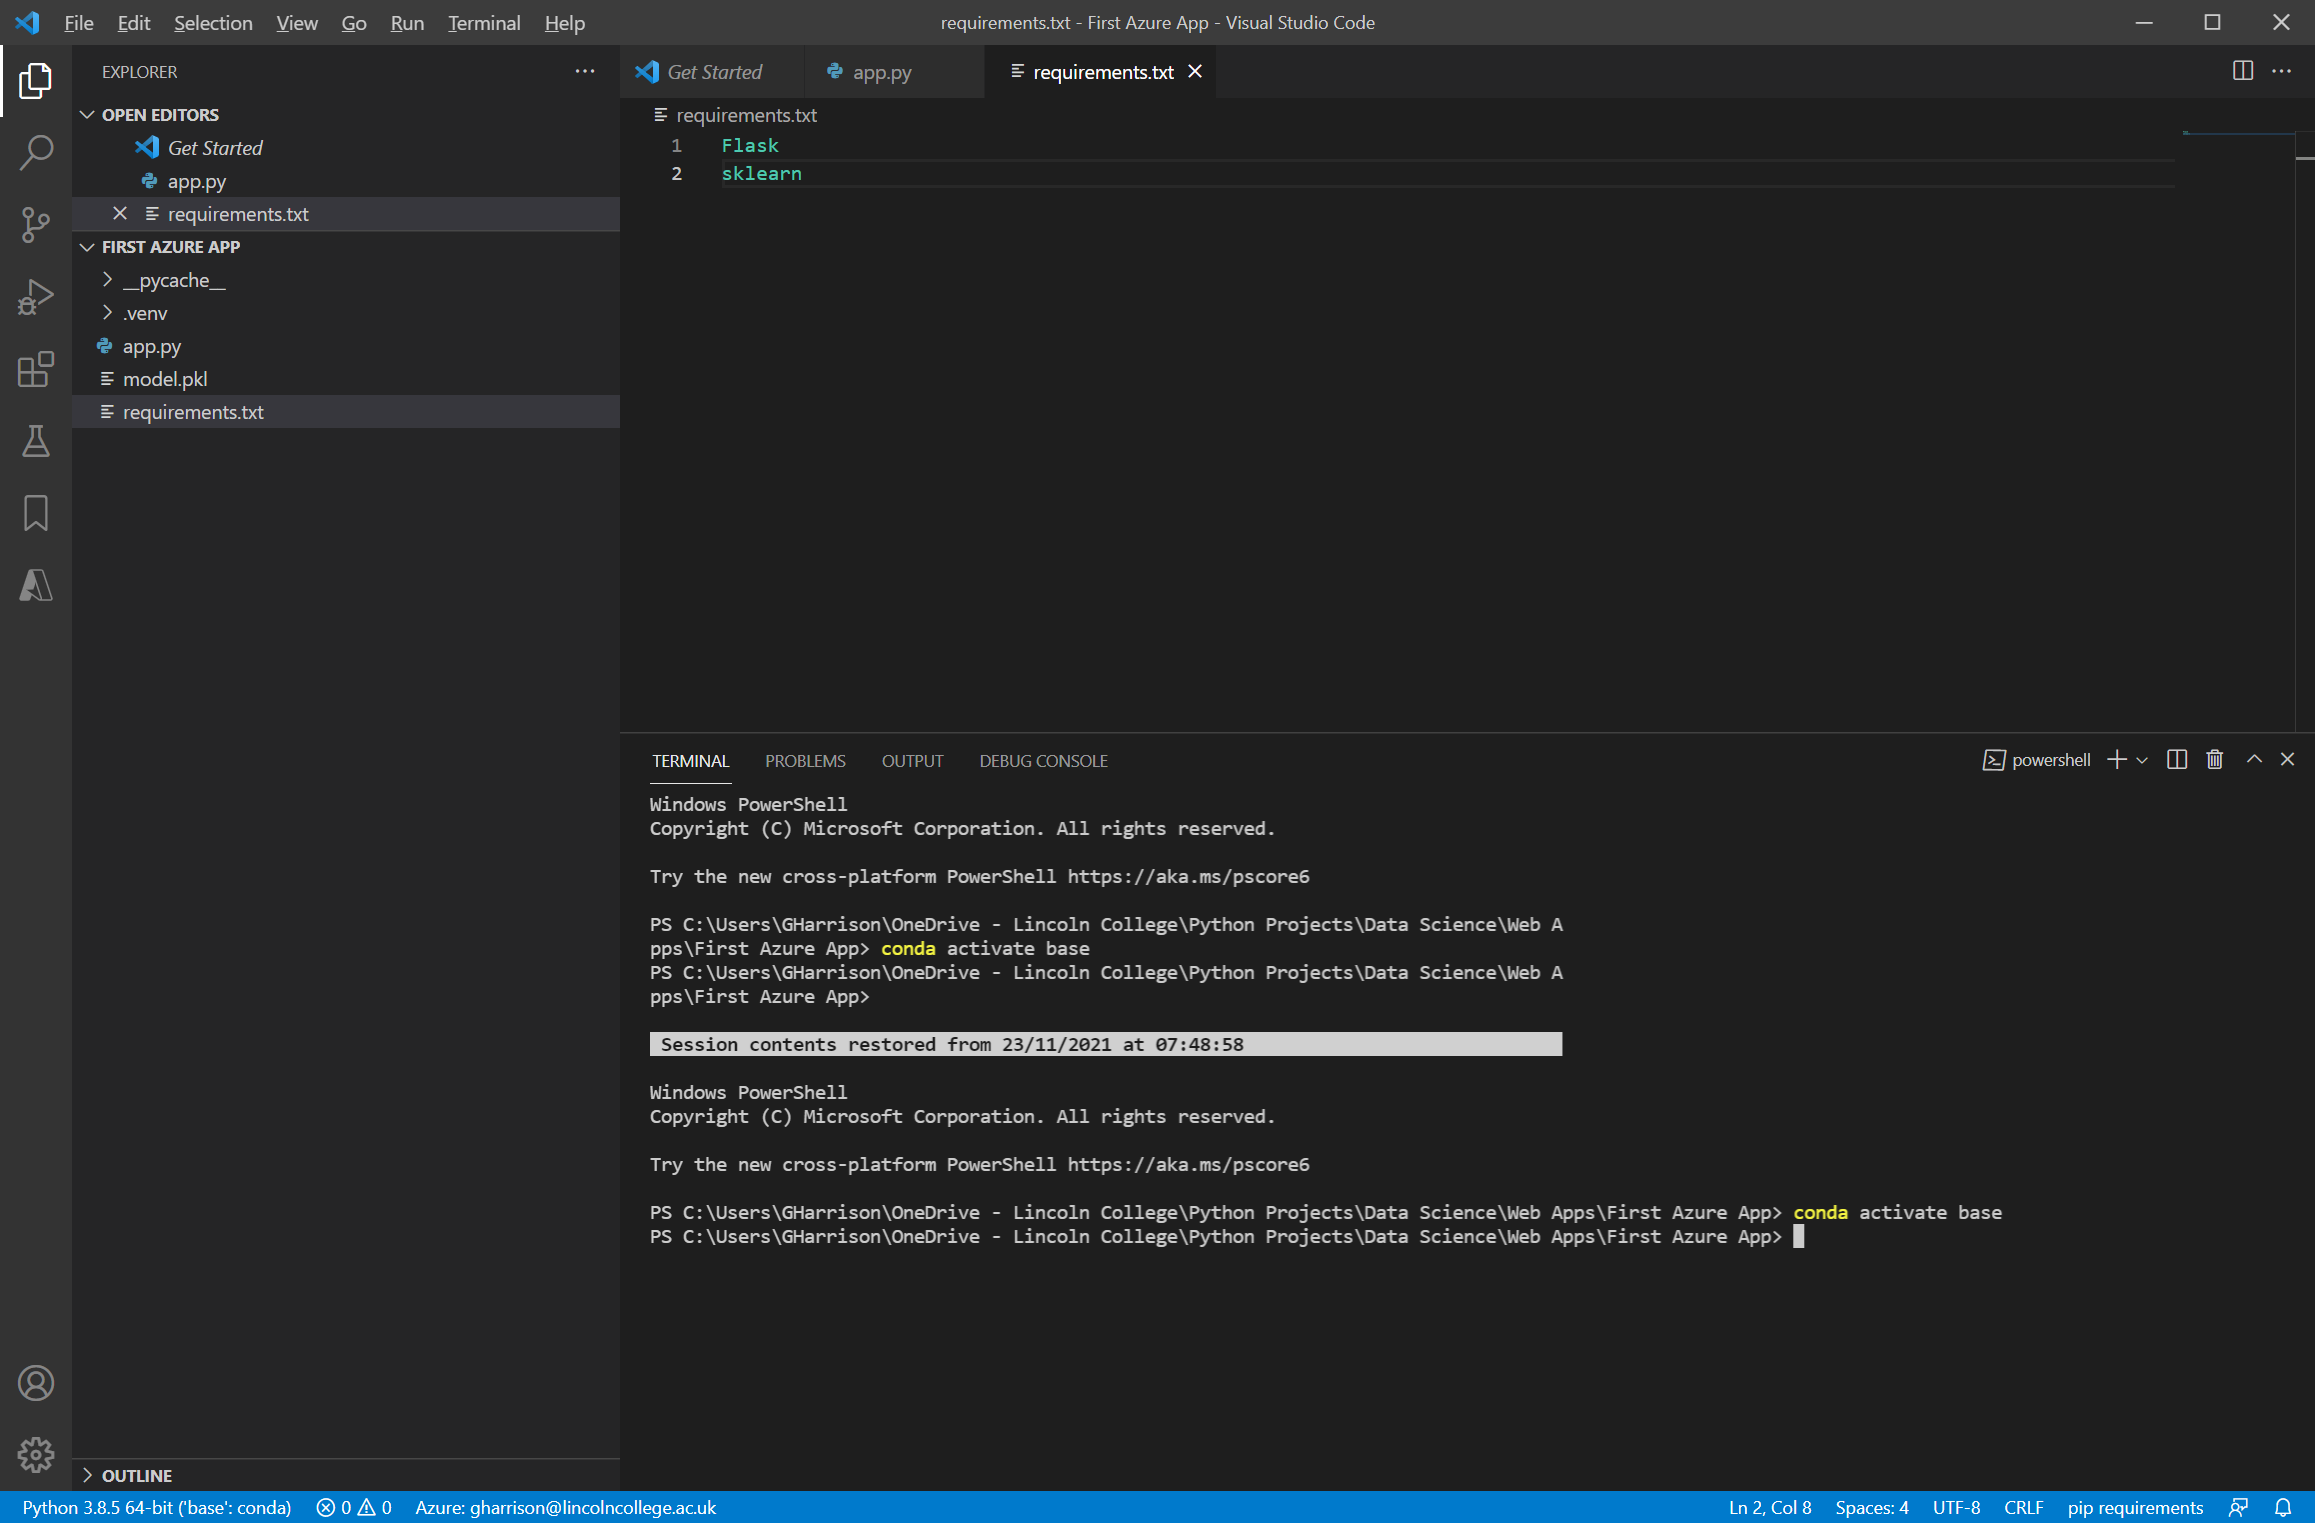

Some points to note -

1. The library names must match exactly to what you would type if you were installing using pip, for example ``pip install Flask``.
2. Note that ``Flask`` has an upper case "F". This is because Flask is unusual in being capitalised this way, usually libraries are all lower case.
3. ``sklearn`` is required to execute the rehydrated ``model.pkl``. Although sklearn and ``DecisionTreeClassifier`` are not referenced explicitly in the code, they are needed for ``model.fit`` so if ``sklearn`` is omitted the app will crash.
4. A reference to ``pickle`` is not required because this library is a part of the core Python installation. If you do include ``pickle`` the deployment will crash because you cannot execute ``pip install pickle``.

If you stick to these rules your deployment will work and any error messages are usually informative enough to enable the issues to be resolved with a bit of Internet research.

#### Step 4.5 Deply Your App to Azure

If you have been following the steps so far you now have a Flask app inside VS Code. Your app code file will be called ``app.py`` and the application name is ``app``. The Flask app has been tested on a local development web server. 

You have installed the VS Code Azure App Extension and used it to create a Microsoft Azure free account and also to create an Azure web application.

You should have your Flask application open in VS Code and you have everything in place to deploy your application into the cloud.

This is achieved by simply clicking on the web app name next to the blue circle icon, then clicking on the cloud icon next to the "+" sign. 

When prompted, choose the following -

- Select the default folder to deploy
- Select the "Free Trial" subscription
- Select the web app name you have created
- If prompted to overwrite, select "Deploy"
- When asked to "Always deploy ..." select "Skip for now"
- When the deployment starts click on "output window"

Now sit back and make a coffee whilst the app deploys -

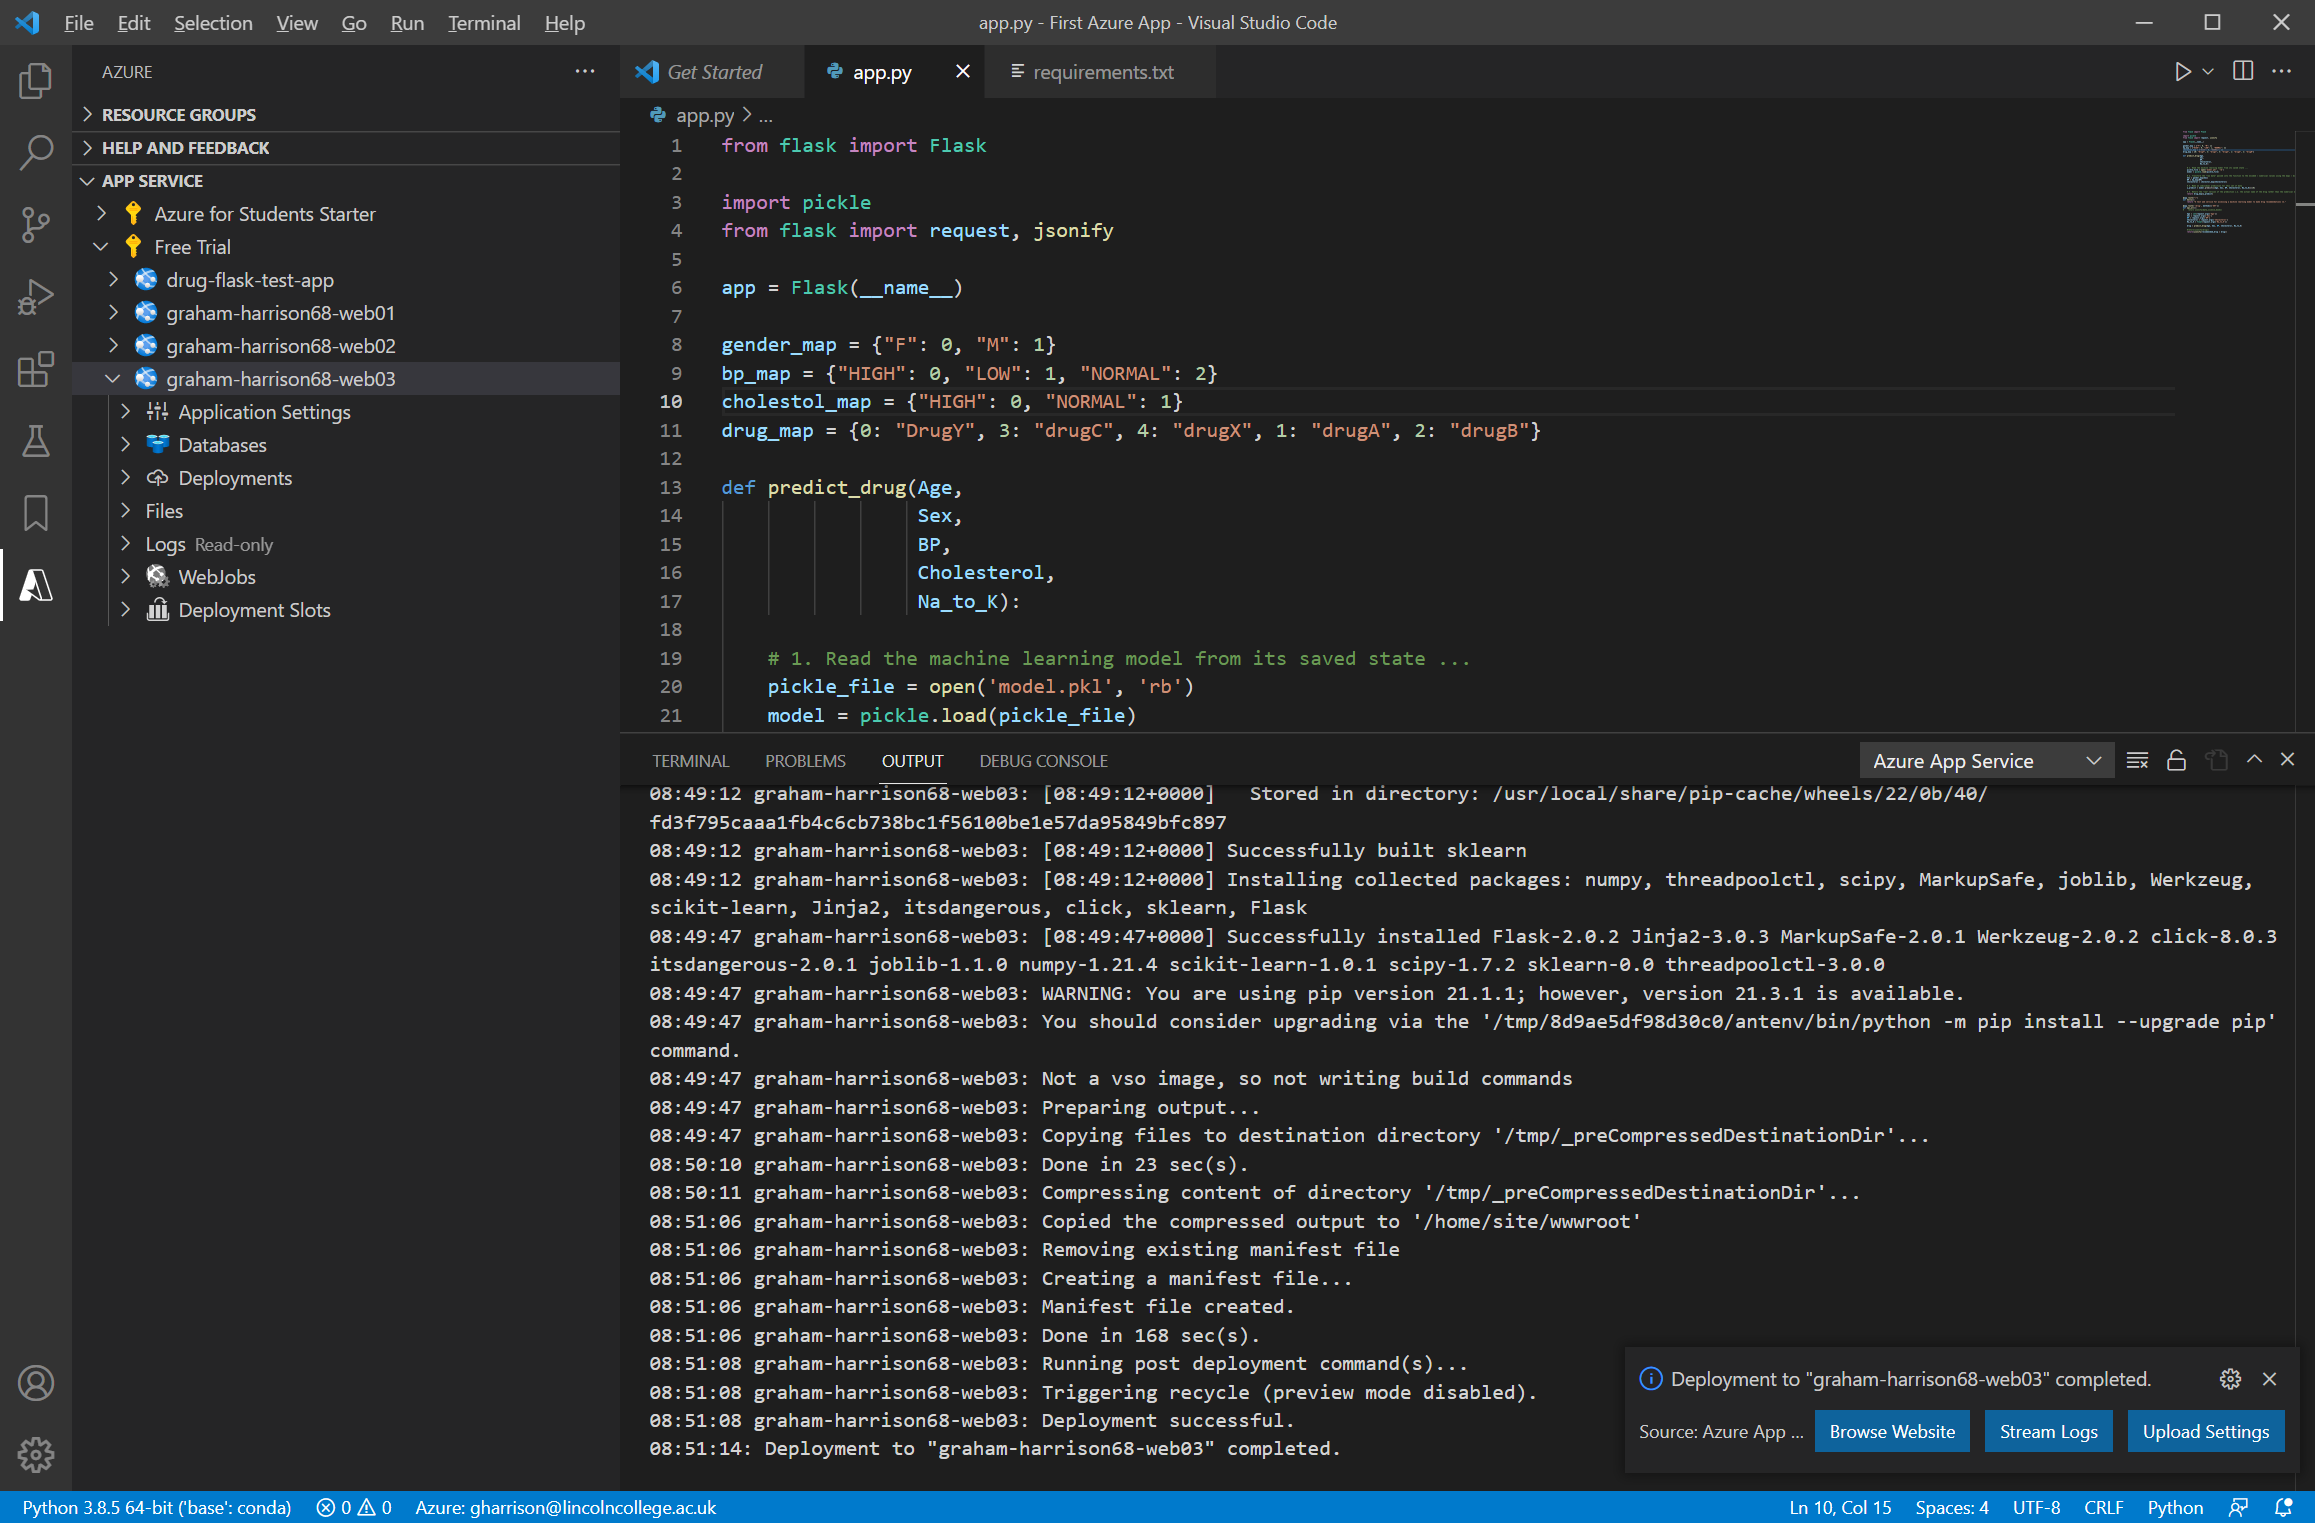

When the deployment is complete, click on "Browse Website" and you will be taken to the correct URL which will run ``app.route("/")`` function.

Simply add in the same URL parameters that we used to test the local deployment and you will see the output from a fully deployed web app! -

https://graham-harrison68-web03.azurewebsites.net/drug?Age=60&Sex=F&BP=LOW&Cholesterol=HIGH&Na_to_K=20

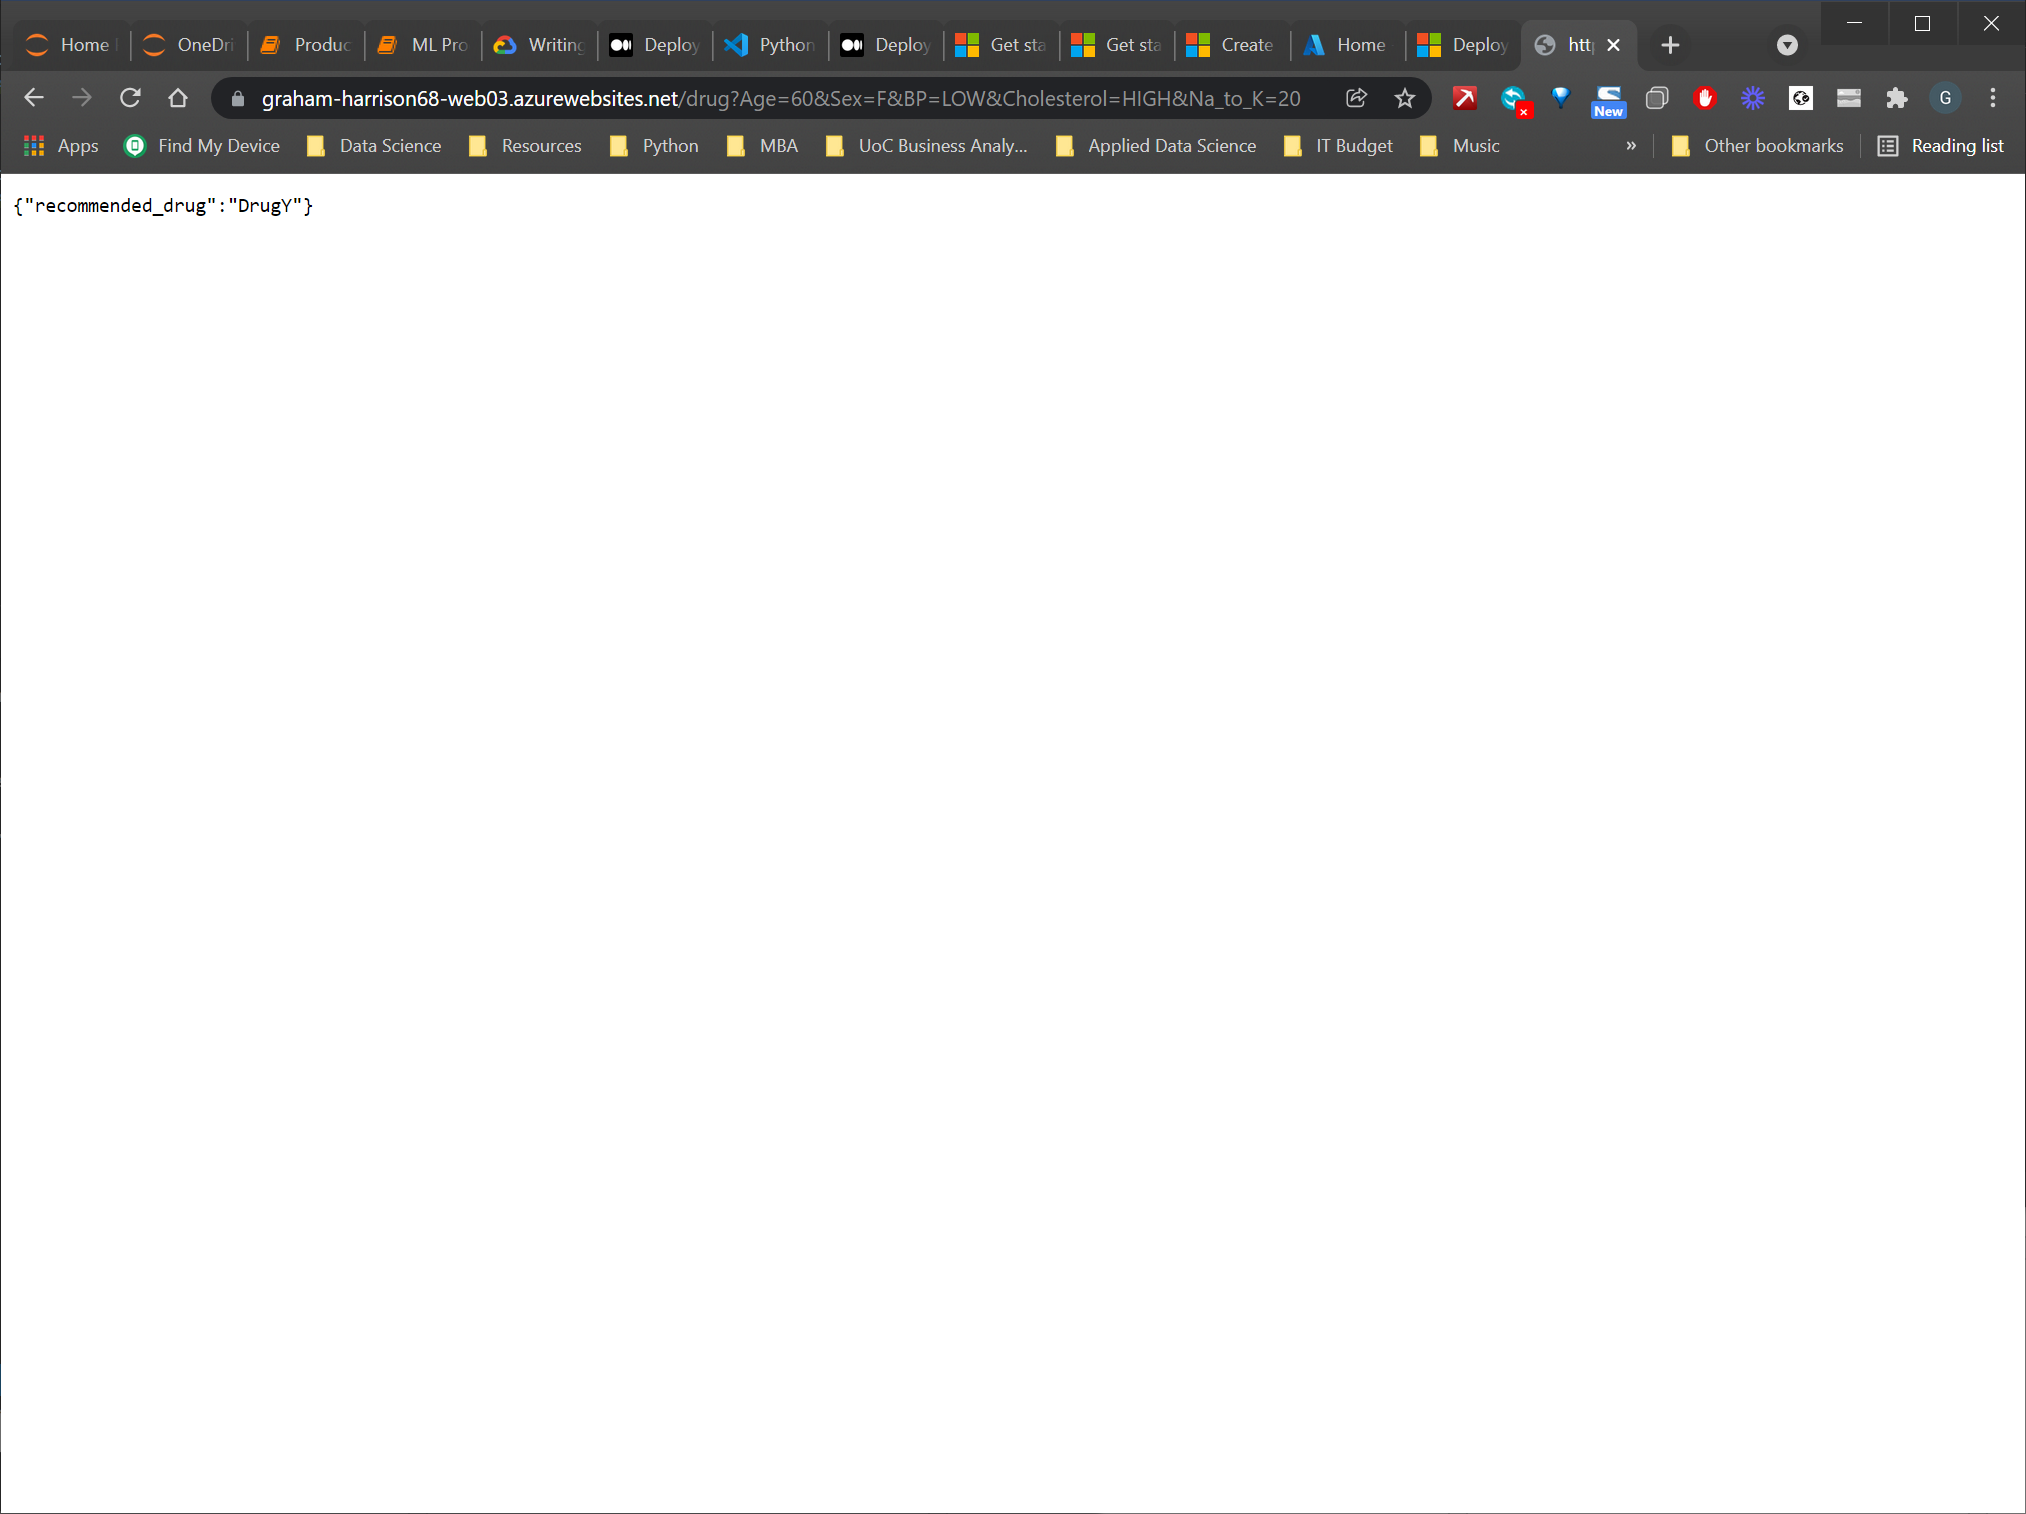

A point to note: after a while the azure app goes to sleep and the first call after this takes a very long time.

If you choose to upgrade to a paid-for Azure subscription there is an option to keep the app refreshed and "awake" but in the free subscription the sleep-related delay cannot be avoided as this subscription is intended for testing purposes and as such has a few limitations.

### Step 5: Building a Client Application to Consume the Azure-deployed Web Service

At this point any programming language or environment that can invoke web requests can call the deployed web service with just a few lines of code.

We did start by saying that non-Python environments like C#, JavaScript etc. can all be used but I will finish off this example by writing some code to call the deployed app from a Python client using ``ipywidgets`` -

In [5]:
import requests
from ipywidgets import Label, BoundedFloatText, BoundedIntText, Dropdown, Button, Output, VBox

prescribe_label = Label('Drug prescription prediction for age, gender, bp, cholesterol and "Na to K"')
age_text = BoundedIntText(min=16, max=100, value=47, description="Age:", disabled=False)
gender_dropdown = Dropdown(options=['F', 'M'], description='Gender:', disabled=False)
bp_dropdown = Dropdown(options=['HIGH', 'LOW', 'NORMAL'], value="LOW", description='BP:', disabled=False)
cholesterol_dropdown = Dropdown(options=['HIGH', 'NORMAL'], description='Cholesterol:', disabled=False)
na_to_k_text = BoundedFloatText(min=0.0, max=50.0, value=14, description="Na to K", disabled=False)
prescribe_button = Button(description="Presribe")
prescribe_output = Output()

# Button click event handlers ...
def prescribe_button_on_click(b):
    
    request_url = f"https://graham-harrison68-web03.azurewebsites.net/drug?Age={age_text.value}&Sex={gender_dropdown.value}&BP={bp_dropdown.value}&Cholesterol={cholesterol_dropdown.value}&Na_to_K={na_to_k_text.value}"
    response = requests.get(request_url)
    recommended_drug = response.json()["recommended_drug"]

    prescribe_output.clear_output()
    with prescribe_output:

        print(f"The recommended drug is {recommended_drug}")
        
prescribe_button.on_click(prescribe_button_on_click)

vbox_prescribe = VBox([prescribe_label, age_text, gender_dropdown, bp_dropdown, cholesterol_dropdown, na_to_k_text, prescribe_button, prescribe_output])

vbox_prescribe

If you click "Prescribe" with the default values, the recommendation should be for "drugC". 

Change the Age to 60 and Na to K to 20 and "DrugY" should be prescribed. Put the Age back to 47, Na to K back to 14 and change BP to "HIGH" and drugA should be prescribed.

These simple tests prove that the Azure-hosted web service using a decision tree based predictive machine learning algorithm is fully deployed to the public cloud, can be called by any development environment capable of executing a ``http GET`` command and is fully working end-to-end.

## Conclusion
There are quite a few steps involved, but using readily available libraries and free tools including scikit-learn, pickle, flask, Microsoft Azure and ipywidgets we have constructed a fully working, publicly available cloud deployment of a machine learning algorithm and a fully functioning client to call and consume the web service and display the results.

## Thank you for reading!
If you enjoyed reading this article, why not check out my other articles at https://grahamharrison-86487.medium.com/?

Also, I would love to hear from you to get your thoughts on this piece, any of my other articles or anything else related to data science and data analytics.

If you would like to get in touch to discuss any of these topics please look me up on LinkedIn — https://www.linkedin.com/in/grahamharrison1 or feel free to e-mail me at GHarrison@lincolncollege.ac.uk.

If you would like to support the author and 1000's of others who contribute to article writing world-wide by subscribing, please use this link - https://grahamharrison-86487.medium.com/membership. Note: the author will receive a proportion of the fees if you sign up using this link.